# Wheat Disease Classification

Dataset credits: https://www.kaggle.com/arjuntejaswi/plant-village

Connect to Google Drive

In [1]:
from google.colab import drive

drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


 **GPU**

In [2]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


**CPU less use**

In [3]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.intra_op_parallelism_threads = 4  # Adjust the number of threads based on your CPU
config.inter_op_parallelism_threads = 4  # Adjust the number of threads based on your CPU
session = InteractiveSession(config=config)


unzip dataset

In [ ]:
import zipfile

# Provide the path to the uploaded zip file
zip_path = '/content/drive/MyDrive/wheat_leaf2.zip'

# Specify the destination directory to extract the files
extract_path = '/content/drive/MyDrive'

# Extract the contents of the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


### Import all the Dependencies

In [4]:
import tensorflow as tf
tf.keras.mixed_precision.set_global_policy('mixed_float16')
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

### Set all the Constants

In [5]:
BATCH_SIZE = 9
IMAGE_SIZE = 224
CHANNELS=3
EPOCHS=30

Resize Images in DataSet

In [7]:
from PIL import Image, UnidentifiedImageError
import os

SIZE = [224, 224]
folders = ['Healthy', 'septoria', 'stripe_rust', 'random']
base_path = '/content/drive/MyDrive/wheat_leaf2'  # Specify the base directory path

for folder in folders:
    folder_path = os.path.join(base_path, folder)

    for filename in os.listdir(folder_path):
        image_path = os.path.join(folder_path, filename)

        try:
            image = Image.open(image_path)
            resized_image = image.resize(SIZE)

            # Check if the original image format is JPEG
            if image.format.lower() != 'jpeg':
                raise ValueError(f"Unsupported image format {image.format}. Only JPEG images are allowed.")

            # Save the resized image as JPEG, overwriting the original image
            resized_image.save(image_path, format='JPEG')

            print(f"Resized {folder} image: {filename}")
        except (UnidentifiedImageError, OSError, ValueError) as e:
            # Handle the error, print a message, and delete the problematic image
            print(f"Error processing {folder} image: {filename}. Deleting. Error: {e}")
            os.remove(image_path)


Streaming output truncated to the last 5000 lines.
Resized random image: image_06729.jpg
Resized random image: image_06728.jpg
Resized random image: image_06730.jpg
Resized random image: image_06732.jpg
Resized random image: image_06735.jpg
Resized random image: image_06731.jpg
Resized random image: image_06733.jpg
Resized random image: image_06734.jpg
Resized random image: image_06736.jpg
Resized random image: image_06737.jpg
Resized random image: image_06739.jpg
Resized random image: image_06738.jpg
Resized random image: image_06740.jpg
Resized random image: image_06742.jpg
Resized random image: image_06741.jpg
Resized random image: image_06743.jpg
Resized random image: image_06745.jpg
Resized random image: image_06744.jpg
Resized random image: image_06746.jpg
Resized random image: image_06748.jpg
Resized random image: image_06747.jpg
Resized random image: image_06750.jpg
Resized random image: image_06749.jpg
Resized random image: image_06753.jpg
Resized random image: image_06752.jpg

### Import data into tensorflow dataset object

We will use image_dataset_from_directory api to load all images in tensorflow dataset: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/wheat_leaf2",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 9260 files belonging to 4 classes.


In [ ]:
len(dataset)

290

Name of Folder in Main Wheat Folder which are classes

In [9]:
class_names = dataset.class_names
class_names

['Healthy', 'random', 'septoria', 'stripe_rust']

In [7]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())#get every element in form of tensor so convert in numpy

(13, 224, 224, 3)
[1 1 1 1 1 1 1 1 1 1 1 1 1]


As you can see above, each element in the dataset is a tuple. First element is a batch of 32 elements of images. Second element is a batch of 32 elements of class labels

### Visualize some of the images from our dataset

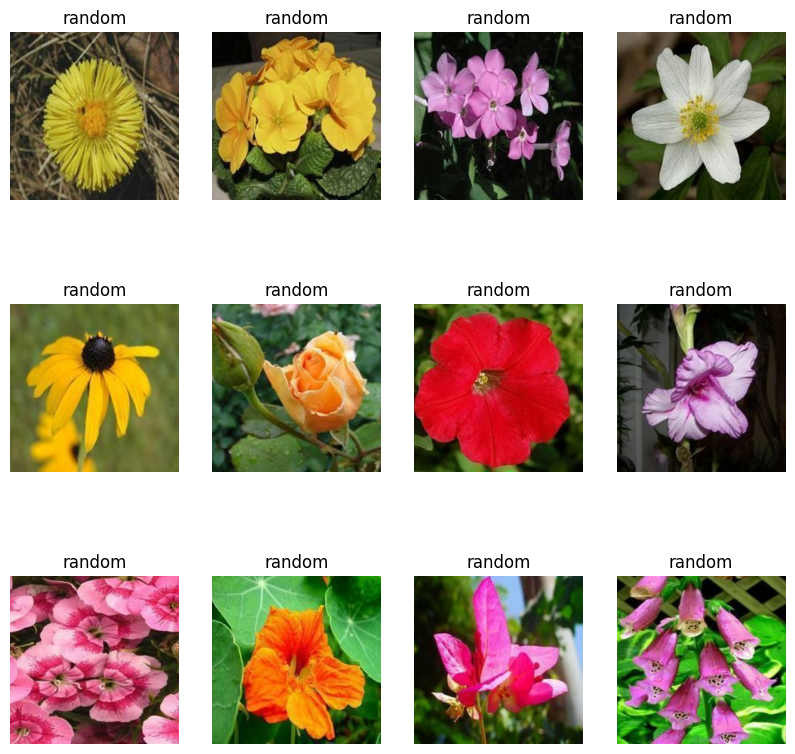

In [10]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

### Function to Split Dataset

Dataset should be bifurcated into 3 subsets, namely:
1. Training: Dataset to be used while training
2. Validation: Dataset to be tested against while training
3. Test: Dataset to be tested against after we trained a model

In [ ]:
len(dataset)

290

In [ ]:
train_size = 0.8
len(dataset)*train_size

232.0

In [ ]:
train_ds = dataset.take(54)
len(train_ds)

54

In [ ]:
test_ds = dataset.skip(54)
len(test_ds)

236

In [ ]:
val_size=0.1
len(dataset)*val_size

29.0

In [ ]:
val_ds = test_ds.take(29)
len(val_ds)

29

In [ ]:
test_ds = test_ds.skip(29)
len(test_ds)

207

In [7]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [8]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds)

232

In [ ]:
len(val_ds)

29

In [ ]:
len(test_ds)

29

### Cache, Shuffle, and Prefetch the Dataset

In [9]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the Model

### Creating a Layer for Resizing and Normalization
Before we feed our images to network, we should be resizing it to the desired size.
Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256).
This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [10]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./225),
])

### Data Augmentation
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [11]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

#### Applying Data Augmentation to Train Dataset

In [12]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

### Model Architecture
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

In [13]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4
model = models.Sequential([
          resize_and_rescale,
          layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
          layers.MaxPooling2D((2, 2)),
          layers.Conv2D(32,  kernel_size = (3,3), activation='relu'),
          layers.MaxPooling2D((2, 2)),
          layers.Conv2D(32,  kernel_size = (3,3), activation='relu'),
          layers.MaxPooling2D((2, 2)),
          layers.Conv2D(32, (3, 3), activation='relu'),
          layers.MaxPooling2D((2, 2)),
          layers.Conv2D(64, (3, 3), activation='relu'),
          layers.MaxPooling2D((2, 2)),
          layers.Flatten(),
          layers.Dense(32, activation='relu'),
          layers.Dense(n_classes, activation='softmax'),
      ])
model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 254, 254, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 252, 252, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 126, 126, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 124, 124, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

### Compiling the Model
We use `adam` Optimizer, `SparseCategoricalCrossentropy` for losses, `accuracy` as a metric

In [14]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [15]:
history = model.fit(
        train_ds,
        batch_size=BATCH_SIZE,
        validation_data=val_ds,
        verbose=1,
        epochs=30,
    )

Epoch 1/30
823/823 [==============================] - 150s 136ms/step - loss: 0.1713 - accuracy: 0.9548 - val_loss: 0.1075 - val_accuracy: 0.9641
Epoch 2/30
823/823 [==============================] - 80s 97ms/step - loss: 0.1036 - accuracy: 0.9565 - val_loss: 0.0841 - val_accuracy: 0.9641
Epoch 3/30
823/823 [==============================] - 78s 95ms/step - loss: 0.1054 - accuracy: 0.9612 - val_loss: 0.0781 - val_accuracy: 0.9684
Epoch 4/30
823/823 [==============================] - 80s 97ms/step - loss: 0.0905 - accuracy: 0.9619 - val_loss: 0.0709 - val_accuracy: 0.9695
Epoch 5/30
823/823 [==============================] - 81s 98ms/step - loss: 0.0928 - accuracy: 0.9637 - val_loss: 0.0657 - val_accuracy: 0.9717
Epoch 6/30
823/823 [==============================] - 79s 96ms/step - loss: 0.0940 - accuracy: 0.9630 - val_loss: 0.0707 - val_accuracy: 0.9695
Epoch 7/30
823/823 [==============================] - 80s 98ms/step - loss: 0.0861 - accuracy: 0.9650 - val_loss: 0.0886 - val_accurac

In [ ]:
scores = model.evaluate(test_ds)

**You can see above that we get 100.00% accuracy for our test dataset. **

In [ ]:
scores

[0.09998790919780731, 0.96875]

Scores is just a list containing loss and accuracy value

### Plotting the Accuracy and Loss Curves

In [18]:
history

You can read documentation on history object here: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History

In [19]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 823}

In [20]:
history.history.keys()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

**loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch**

In [21]:
type(history.history['loss'])

list

In [22]:
len(history.history['loss'])

30

In [23]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.17132611572742462,
 0.10357197374105453,
 0.1053880900144577,
 0.09050707519054413,
 0.09278833866119385]

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

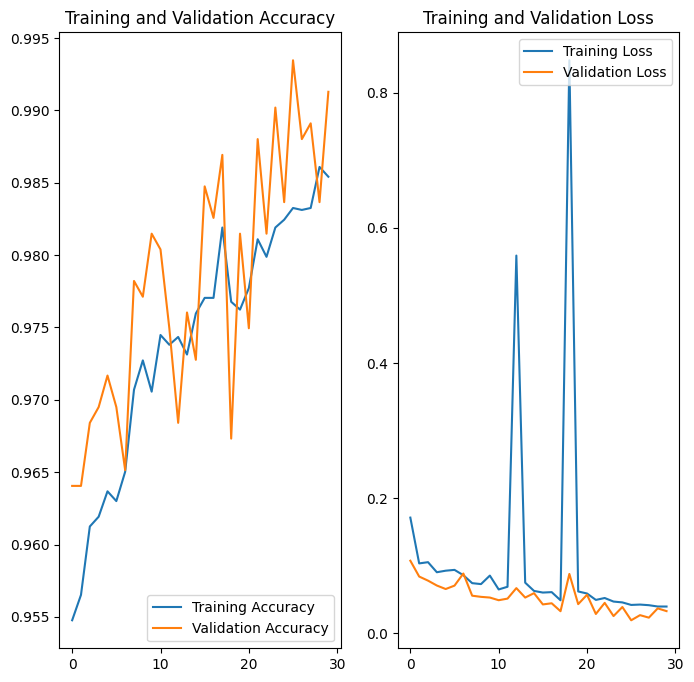

In [25]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Run prediction on a sample image

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

### Write a function for inference

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

**Now run inference on few sample images**

1/1 [==============================] - 0s 20ms/step


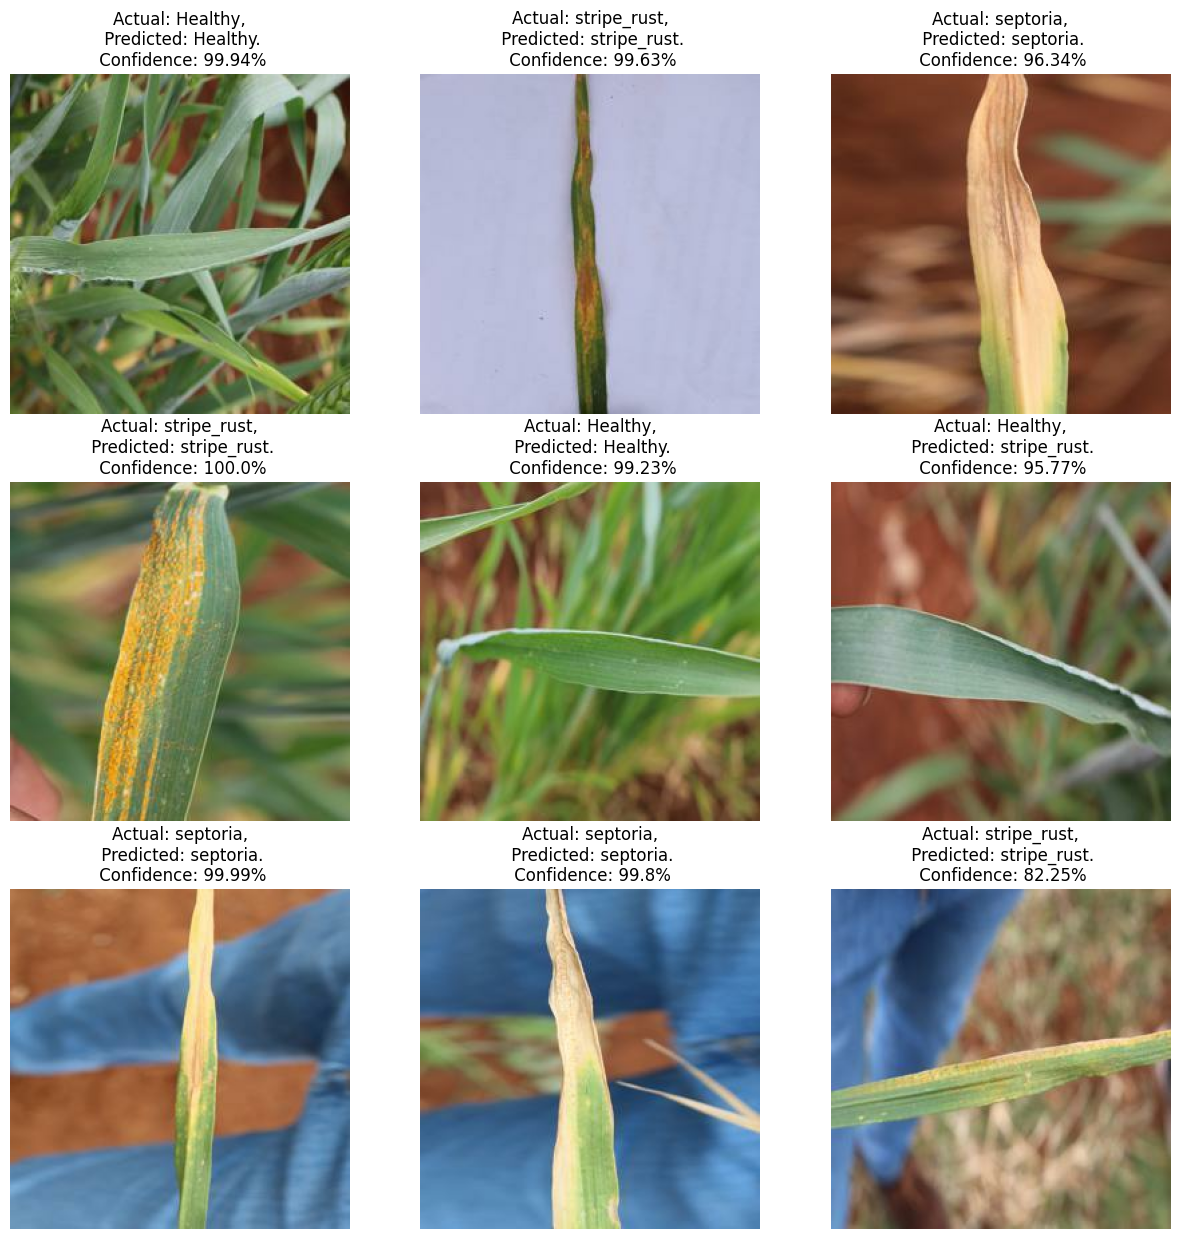

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

### Saving the Model
We append the model to the list of models as a new version

In [16]:
import os
model_version=max([int(i) for i in os.listdir("/content/drive/MyDrive/model") + [0]])+1
model.save(f"/content/drive/MyDrive/model/{model_version}")

In [17]:
model.save("../wheat.h6")